In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from matplotlib import rcParams
from TurbCurv import orr_sommerfeld

%matplotlib inline
plt.rc('text',usetex=True)
plt.rc('font',family='serif')
rcParams.update({'figure.autolayout': True})



(0.0, 1.0)

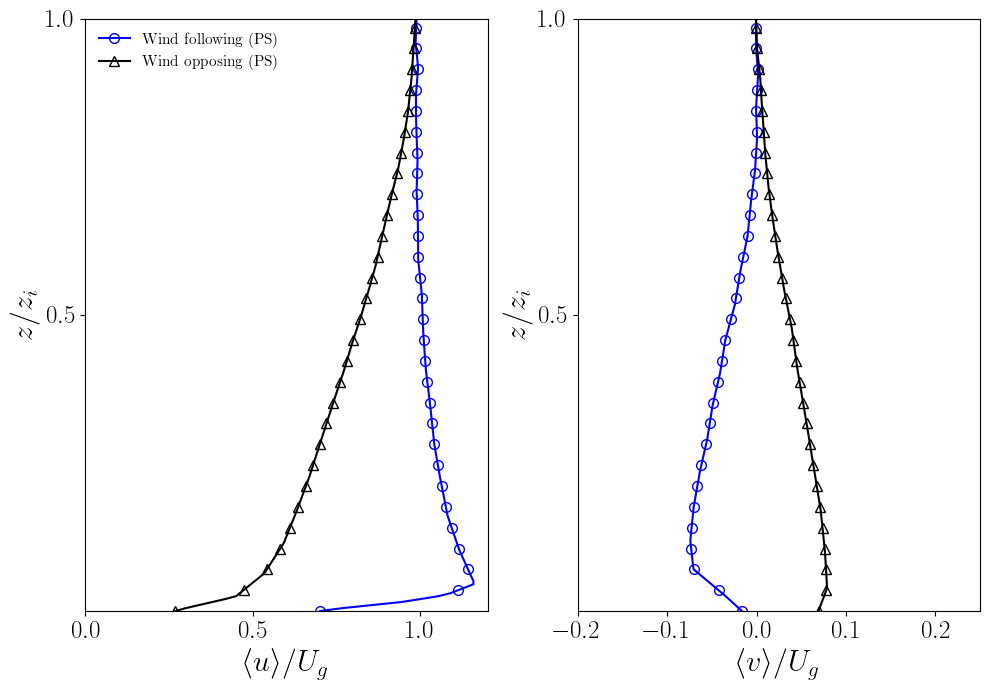

In [2]:
#### Read in profiles from Sullivan

sully_path='./sullivan_data/'

class profile_sullivan:
    def __init__(self,Filename):
        DATA=np.genfromtxt(Filename,delimiter=',',skip_header=1)
        Ug=5
        Vg=0.
        zi=400.
        self.z=DATA[:,0]*zi
        self.U=DATA[:,1]*Ug
        self.V=DATA[:,2]*Ug
        self.u2=DATA[:,3]
        self.v2=DATA[:,4]
        self.w2=DATA[:,5]
        
WindFollowing=profile_sullivan(sully_path+'WindFollowing.dat')
WindOpposing=profile_sullivan(sully_path+'WindOpposing.dat')

zi=400

Ug=5
Vg=0.
markS=7
Every=7
plt.figure(11,figsize=(10,7))
ax1=plt.subplot(121)
ax1.plot(WindFollowing.U/Ug,WindFollowing.z/zi,'-ob',markerfacecolor='none',markersize=markS,markevery=Every,label='Wind following (PS)')
ax1.plot(WindOpposing.U/Ug,WindOpposing.z/zi,'-^k',markerfacecolor='none',markersize=markS,markevery=Every,label='Wind opposing (PS)')
ax1.set_ylabel(r'$z/z_i$',fontsize=22)
ax1.set_xlabel(r'$\langle u \rangle/U_g$',fontsize=22)
ax1.set_xticks([0,.5,1.0])
ax1.set_yticks([0.5,1])
ax1.tick_params(labelsize=18)
ax1.set_xlim(0.,1.2)
ax1.set_ylim(0,1)
ax1.legend(fontsize=11,frameon=False)
ax2=plt.subplot(122)
ax2.plot(WindFollowing.V/Ug,WindFollowing.z/zi,'-ob',markerfacecolor='none',markersize=markS,markevery=Every,label='Wind following (PS)')
ax2.plot(WindOpposing.V/Ug,WindOpposing.z/zi,'-^k',markerfacecolor='none',markersize=markS,markevery=Every,label='Wind opposing (PS)')
ax2.set_ylabel(r'$z/z_i$',fontsize=22)
ax2.set_xlabel(r'$\langle v \rangle/U_g$',fontsize=22)
ax2.set_xticks([-0.2,-0.1,0.,0.1,0.2])
ax2.set_yticks([0.5,1])
ax2.tick_params(labelsize=18)
ax2.set_xlim(-0.2,0.25)
ax2.set_ylim(0,1)

(2048,)
(2048, 2048) (2048,)
Solution at the boundaries:
w(0) = (0.6283185307195108-1.6795731472285524e-12j)
w'(0) = (0.04338531476640341+0j)
w(H) = 0j
w'(1) = 0j


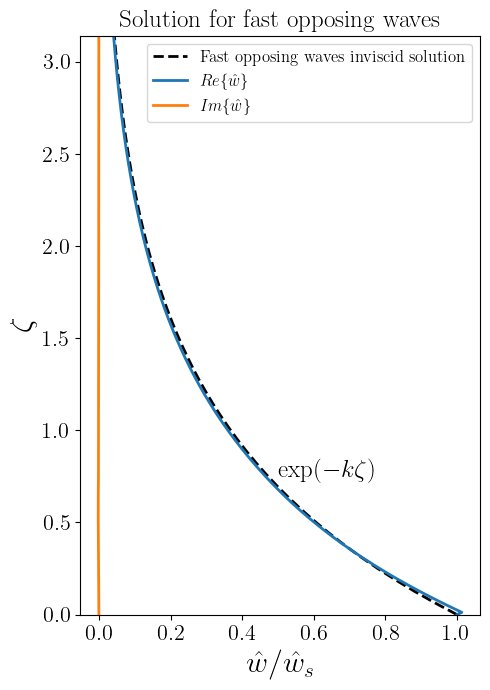

In [9]:
# Problem Parameters
N = 2048
a=1.6 # in meters 
nu=0.00001
k=2*np.pi/100. 
c=-12.5 # in meter per second
zi=400


ustar=0.4
# Mean profile taken from Sullivan et al 2008
z = np.linspace(0, zi, N)
U = np.interp(z,WindOpposing.z,WindOpposing.U)
U_prime = np.gradient(U,z,edge_order=2)
U_double_prime=np.gradient(U_prime,z,edge_order=2)
U_triple_prime=np.gradient(U_double_prime,z,edge_order=2)

# calculate turbulent eddy viscosity
kappa=0.4
z0=0.0001
nuT=ustar*kappa*(z+z0)
nuT_prime=ustar*kappa


# Inhomogeneous term
g = lambda z, zi: z/zi -1
f = -(nu+nuT)*a/2*np.gradient(np.gradient(g(z,zi)*U_double_prime,z,edge_order=2))+nuT_prime*a/2.*(2*np.gradient(np.gradient(g(z,zi)*U_prime,z,edge_order=2))-k**2*g(z,zi)*U_prime)
print(np.shape(f))
# Boundary conditions: [phi(-1), phi'(-1), phi(1), phi'(1)]
w_s=-0.5*a*k*c
dwdz_s=-0.5*a*k**2*c+0.5*a*k*U_prime[0]
z_bc = [w_s,dwdz_s,0.0, 0.0]


# Solve Orr-Sommerfeld equation
z, w = orr_sommerfeld(N, zi, nu, nuT, nuT_prime, k, U, c, U_double_prime, f,z_bc)

# Plot the solution
plt.figure(1,figsize=(5,7))
plt.title(r'Solution for fast opposing waves', fontsize=18)
x_plot = np.linspace(0, 100, 100)
y_plot = np.exp(-k*x_plot)
plt.plot(y_plot,k*x_plot,'--k',linewidth=2,label=r'Fast opposing waves inviscid solution')
plt.text(0.5, 0.75, r'$\exp(-k\zeta)$', fontsize=18)
plt.plot(np.real(w)/w_s,k*z, linewidth=2,label=r'$Re\{\hat{w}\}$')
plt.plot(np.imag(w)/w_s,k*z, linewidth=2, label=r'$Im\{\hat{w}\}$')
plt.xlabel(r'$\hat{w}/\hat{w}_s$',fontsize=22)
plt.ylabel(r'$\zeta$',fontsize=22)
plt.ylim(0,np.pi)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.savefig('SolutionForFastOpposingWaves.pdf',format='pdf',dpi=100,bbox_inches='tight', 
               transparent=True,
               pad_inches=0)

# Print the solution at the boundaries
Rewopposing=np.real(w)
print("Solution at the boundaries:")
print(f"w(0) = {w[0]}")
print(f"w'(0) = {(w[1] - w[0]) / (z[1] - z[0])}")
print(f"w(H) = {w[-1]}")
print(f"w'(1) = {(w[-1] - w[-2]) / (z[-1] - z[-2])}")

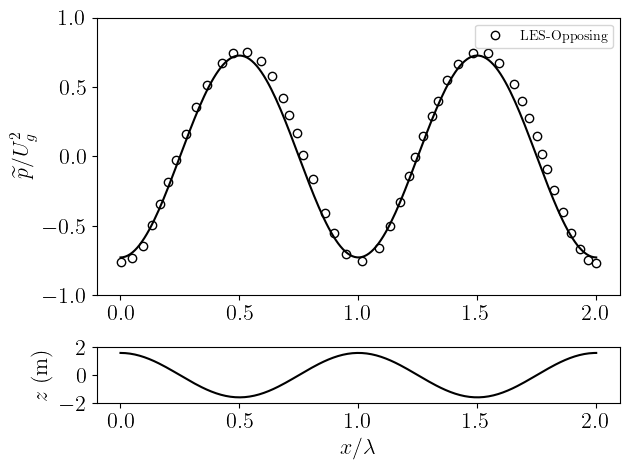

In [8]:
#### Compute pressure

### Compute pressure
Imp_opposing=np.zeros(N)

U=np.interp(z,WindOpposing.z,WindOpposing.U)
c=-12.5
for i in range(N):
    Imp_opposing[i]=np.trapz(k*(U[i:]-c)*Rewopposing[i:],z[i:])

x = np.linspace(0,200,200)
y = a*np.cos(k*x)

# plot it
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]})

a0.plot(x/100, -2*Imp_opposing[0]/Ug**2*np.sin(k*x+np.pi/2),'k')

a0.set_ylabel(r'$\widetilde{p}/U_g^2$',fontsize=16)
a0.tick_params(labelsize=16)
a0.set_ylim(-1,1)

OpposingLES=np.genfromtxt(sully_path+'OpposingLES.csv',delimiter=',')
a0.plot(OpposingLES[:,0],OpposingLES[:,1],'ok',markerfacecolor='none',label='LES-Opposing')
a0.legend()

#plot free surface
a1.plot(x/100, y,'k')
a1.set_ylabel(r'$z$ (m)',fontsize=16)
a1.set_xlabel(r'$x/\lambda$',fontsize=16)
a1.tick_params(labelsize=16)
a1.set_ylim(-2,2)


f.tight_layout()
plt.savefig('SurfacePressure_ComparisonWithLES.png',format='png',dpi=100,bbox_inches='tight', 
               transparent=False,
               pad_inches=0.01)